In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [2]:
df = pd.read_csv("AirQuality_cleaned.csv")
df.head()
df.columns


Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [3]:
features = df[['NO2(GT)', 'NOx(GT)']]
target = df[['CO(GT)']]


In [4]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)


In [5]:
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, 24)


In [6]:
print(X_seq.shape)
print(y_seq.shape)


(9447, 24, 2)
(9447, 1)


In [7]:
split = int(0.8 * len(X_seq))

X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


In [8]:
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(24, 2)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\darsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,651 (41.61 KB)

 Trainable params: 10,651 (41.61 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1024 - val_loss: 0.0547
Epoch 2/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0748 - val_loss: 0.0404
Epoch 3/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0703 - val_loss: 0.0478
Epoch 4/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0661 - val_loss: 0.0419
Epoch 5/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0640 - val_loss: 0.0369
Epoch 6/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0628 - val_loss: 0.0360
Epoch 7/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0617 - val_loss: 0.0365
Epoch 8/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0610 - val_loss: 0.0378
Epoch 9/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0606 - val_loss: 0.0367
Epoch 10/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0602 - val_loss: 0.0364
Epoch 11/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0599 - val_loss: 0.0399
Epoch 12/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

In [10]:
model.save("lstm_air_quality_model.keras")

import joblib
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")


['scaler_y.pkl']

In [11]:
y_pred = model.predict(X_test)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [12]:
# Inverse transform (back to original CO(GT) values)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


In [13]:
for i in range(5):
    print(f"Actual: {y_test_inv[i][0]:.2f} | Predicted: {y_pred_inv[i][0]:.2f}")


Actual: 2.30 | Predicted: 3.89
Actual: 3.00 | Predicted: 0.45
Actual: 4.50 | Predicted: 5.68
Actual: 6.00 | Predicted: 8.13
Actual: 4.30 | Predicted: 3.63


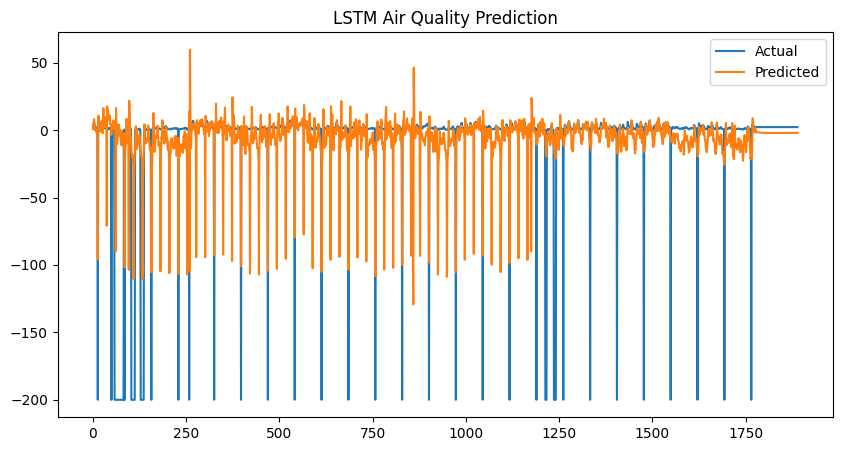

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.legend()
plt.title("LSTM Air Quality Prediction")
plt.show()


In [15]:
model.save("lstm_air_quality_model.keras")
print("Model saved successfully")


Model saved successfully


In [16]:
import pickle

pickle.dump(scaler_X, open("scaler_X.pkl", "wb"))
pickle.dump(scaler_y, open("scaler_y.pkl", "wb"))

print("Scalers re-saved successfully")


Scalers re-saved successfully
